In this notebook we will be using an training an ANN on single point fluorescent spectra (ex: 290) to determine how adulterated maple samples are and with what adulterant (corn, rice, or beet)

Load modules first.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import scipy as sp
from numpy.random import seed

Set a random seed so that if we like a particular training outcome, we can return to it.

In [2]:
seed(88)
tf.random.set_seed(88)

Reading the data from a csv. The features are the excitation wavelengths in nanometers. The first column represents the type of syrup, adulterant and how much.

For example: 

AmBD1 is Amber, Beet Dilute, 1%

DrCD2 is Dark, Corn Dilute, 2%

DrRD5 is Dark, Rice Dilute, 5%

Notice that 1-1%, 2-2%, 3-5%, 4-10%, 5-20%, 6-50%.

In [3]:
#Read data and create training and testing sets
Data=pd.read_csv(r"C:\Users\maiaz\Desktop\Corradini Lab\Amber Every 5 (ex290350) No Corn.csv",header=0)
X_data=Data.iloc[:,1:].values
y_data=Data.iloc[:,0].values

Data.head()

,Unnamed: 0,310,315,320,325,330,335,340,345,350,...,505.1,510.1,515.1,520.1,525.1,530.1,535.1,540.1,545.1,550.1
0,AmBD1,57020.0,65640.0,90500.0,89310.0,79990.0,82840.0,89860.0,93300.0,98220.0,...,91710.0,84230.0,77860.0,68760.0,63580.0,58170.0,51740.0,46200.0,41440.0,36770.0
1,AmBD1,56990.0,65480.0,90020.0,89690.0,79380.0,83210.0,88720.0,94530.0,100650.0,...,91140.0,84830.0,77220.0,69990.0,64600.0,57250.0,50950.0,45990.0,42210.0,36430.0
2,AmBD1,58160.0,66530.0,90710.0,90390.0,79340.0,83490.0,88730.0,94700.0,100640.0,...,91100.0,82010.0,75950.0,70020.0,62960.0,56830.0,50960.0,46040.0,42220.0,35990.0
3,AmBD1,58490.0,67950.0,92620.0,90050.0,81250.0,83680.0,89110.0,92760.0,98720.0,...,89480.0,83580.0,76620.0,70600.0,63280.0,56670.0,50120.0,47130.0,41840.0,36740.0
4,AmBD1,58030.0,66520.0,92030.0,88400.0,79790.0,83810.0,88340.0,91550.0,98610.0,...,90720.0,84260.0,76070.0,69310.0,62530.0,56450.0,51050.0,46610.0,41260.0,36340.0


This simply creates a list of the classes in order of the way for presentation of the results.

In [4]:
classlist=list()
for x in y_data:
    if x not in classlist: 
        classlist.append(x)  

Splitting the data into training and testing sets with a 33/67 split. The data is  shuffled and the classes labels of the testing set are saved before they are one-hot encoded for later.

In [5]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.30, shuffle= True, stratify=y_data)
y_test_realnames=y_test

I wasn't sure how to do this more efficiently. The class names are one-hot encoded for both the testing and training set.

In [6]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test_preencoded=le.fit_transform(y_test)
y_test=le.fit_transform(y_test)
from tensorflow.keras.utils import to_categorical
y_train=(to_categorical(y_train))
y_test=(to_categorical(y_test))

The training data is normalized row by row as opposed to all at once due to the wide range of fluorescent intensity between samples. 

In [7]:
#feature scaling
def rownorm(x):
    """Normalize each row of the matrix
    Argument: x - an (n,m) matrix
    Return: x - row normalized (n,m) matrix"""
    
    x_norm = sp.linalg.norm(x, ord=2, axis=1, keepdims=True)
    x= x/x_norm
    return x
    
X_train = rownorm(X_train)
X_test = rownorm(X_test)

The training data is then split into validation and the final testing sets with a 25/75 split. y_train is stratefied to preserve the proportions of classes in each set. This would probably not work with an unbalanced dataset.

In [8]:
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train, y_train, test_size=0.25, shuffle= True, stratify=y_train)

The model is built. The input layer has as many units as there are columns (features). For the output, "softmax" is used because it is a multi-class classification problem. Early stopping and a dropout layer are used to reduce overfitting. The number of layers and their units (aside from the first and last) were decided by just playing around with the numbers.

In [11]:
#Building the model
ann=tf.keras.models.Sequential()
#Adding input layer
ann.add(tf.keras.layers.Dense(units=86,activation="relu"))
#Adding 1st Hidden Layer 
ann.add(tf.keras.layers.Dense(units=66,activation="relu"))
#dropout layer to prevent overfit
ann.add(tf.keras.layers.Dropout(0.17)),
#Adding 2nd Hidden Layer
ann.add(tf.keras.layers.Dense(units=46,activation="relu"))
#Adding 3rd Hidden Layer
ann.add(tf.keras.layers.Dense(units=26,activation="relu"))
#Adding 4th Hidden Layer
#ann.add(tf.keras.layers.Dense(units=30,activation="relu"))
#Output layer
ann.add(tf.keras.layers.Dense(units=15,activation="softmax"))
#Compiling ANN
ann.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
#Configure early stopping to prevent overfit
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=17)

Although it's set to 1000 epochs, it never reaches even close due to early stopping.

In [12]:
#Fitting ANN
history=ann.fit(x=X_train, y=y_train, batch_size=30, epochs=1000, validation_data=(X_valid, y_valid), callbacks=[es])

Epoch 1/1000
8/8 [==============================] - 1s 29ms/step - loss: 2.7109 - accuracy: 0.0135 - val_loss: 2.7046 - val_accuracy: 0.0179
Epoch 2/1000
8/8 [==============================] - 0s 6ms/step - loss: 2.7029 - accuracy: 0.0631 - val_loss: 2.6991 - val_accuracy: 0.0714
Epoch 3/1000
8/8 [==============================] - 0s 6ms/step - loss: 2.6998 - accuracy: 0.0766 - val_loss: 2.6896 - val_accuracy: 0.1071
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 2.6902 - accuracy: 0.1171 - val_loss: 2.6775 - val_accuracy: 0.1786
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.6778 - accuracy: 0.1577 - val_loss: 2.6575 - val_accuracy: 0.1071
Epoch 6/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.6572 - accuracy: 0.1216 - val_loss: 2.6269 - val_accuracy: 0.1429
Epoch 7/1000
8/8 [==============================] - 0s 6ms/step - loss: 2.6221 - accuracy: 0.1396 - val_loss: 2.5818 - val_accuracy: 0.2321
Epoch 8/1000
8/8 [=

8/8 [==============================] - 0s 7ms/step - loss: 0.7412 - accuracy: 0.6847 - val_loss: 0.5176 - val_accuracy: 0.9107
Epoch 60/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.7875 - accuracy: 0.6667 - val_loss: 0.5431 - val_accuracy: 0.8393
Epoch 61/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.6403 - accuracy: 0.7748 - val_loss: 0.5108 - val_accuracy: 0.9107
Epoch 62/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.7109 - accuracy: 0.7387 - val_loss: 0.4835 - val_accuracy: 0.9107
Epoch 63/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.6516 - accuracy: 0.7342 - val_loss: 0.4872 - val_accuracy: 0.8929
Epoch 64/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.6592 - accuracy: 0.7523 - val_loss: 0.5041 - val_accuracy: 0.8393
Epoch 65/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.6745 - accuracy: 0.7297 - val_loss: 0.4661 - val_accuracy: 0.8750
Epoch 66/1000
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.4275 - accuracy: 0.8288 - val_loss: 0.3059 - val_accuracy: 0.8929
Epoch 118/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4413 - accuracy: 0.8108 - val_loss: 0.2906 - val_accuracy: 0.8929
Epoch 119/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4951 - accuracy: 0.7883 - val_loss: 0.2637 - val_accuracy: 0.9286
Epoch 120/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4361 - accuracy: 0.8288 - val_loss: 0.2947 - val_accuracy: 0.8750
Epoch 121/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4882 - accuracy: 0.8018 - val_loss: 0.2673 - val_accuracy: 0.9286
Epoch 122/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4418 - accuracy: 0.8153 - val_loss: 0.2693 - val_accuracy: 0.9286
Epoch 123/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4402 - accuracy: 0.8198 - val_loss: 0.2615 - val_accuracy: 0.9286
Epoch 124/1000
8/8 [=

Epoch 175/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.3403 - accuracy: 0.8559 - val_loss: 0.2132 - val_accuracy: 0.9286
Epoch 176/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.3373 - accuracy: 0.8559 - val_loss: 0.2181 - val_accuracy: 0.9107
Epoch 177/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.3490 - accuracy: 0.8288 - val_loss: 0.2051 - val_accuracy: 0.9286
Epoch 178/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.3290 - accuracy: 0.8739 - val_loss: 0.1914 - val_accuracy: 0.9286
Epoch 179/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.3888 - accuracy: 0.8604 - val_loss: 0.2256 - val_accuracy: 0.9107
Epoch 180/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.3705 - accuracy: 0.8514 - val_loss: 0.2051 - val_accuracy: 0.9107
Epoch 181/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.3545 - accuracy: 0.8694 - val_loss: 0.1992 - val_accuracy: 0.9286
Epoch 

Epoch 233/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.2714 - accuracy: 0.8829 - val_loss: 0.1579 - val_accuracy: 0.9643
Epoch 234/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.2939 - accuracy: 0.8784 - val_loss: 0.1788 - val_accuracy: 0.9643
Epoch 235/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.2673 - accuracy: 0.8919 - val_loss: 0.1766 - val_accuracy: 0.9286
Epoch 236/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.2846 - accuracy: 0.8739 - val_loss: 0.1939 - val_accuracy: 0.8929
Epoch 237/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.2875 - accuracy: 0.8784 - val_loss: 0.1589 - val_accuracy: 0.9643
Epoch 238/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.2815 - accuracy: 0.8694 - val_loss: 0.1804 - val_accuracy: 0.9286
Epoch 239/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.2861 - accuracy: 0.8694 - val_loss: 0.1639 - val_accuracy: 0.9286
Epoch 

Printing the training and testing accuracy and plotting the losses of the validation and training datasets against eachother.

3/3 [==============================] - 0s 2ms/step - loss: 0.4164 - accuracy: 0.8750
Train: 0.887, Test: 0.875


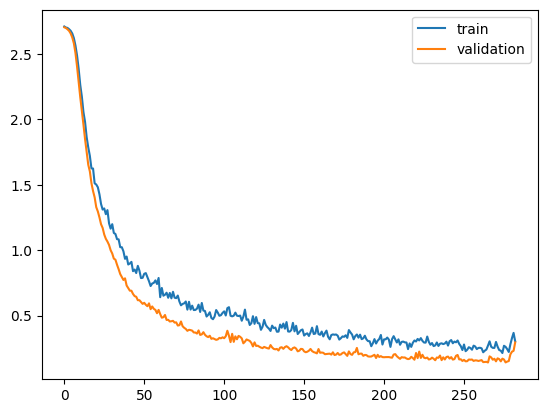

In [13]:
_,train_acc = ann.evaluate(X_train, y_train)
_,test_acc = ann.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
#plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

Just a summary of the ANN architecture.

In [14]:
ann.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 86)                7482      
                                                                 
 dense_6 (Dense)             (None, 66)                5742      
                                                                 
 dropout_1 (Dropout)         (None, 66)                0         
                                                                 
 dense_7 (Dense)             (None, 46)                3082      
                                                                 
 dense_8 (Dense)             (None, 26)                1222      
                                                                 
 dense_9 (Dense)             (None, 15)                405       
                                                                 
Total params: 17,933
Trainable params: 17,933
Non-trai

This is an attempt to display the ANN's top picks when it evaluated the testing set. It's important to include this because we can see where it's getting confused and with what certainty it's deciding. 

3/3 [==============================] - 0s 8ms/step


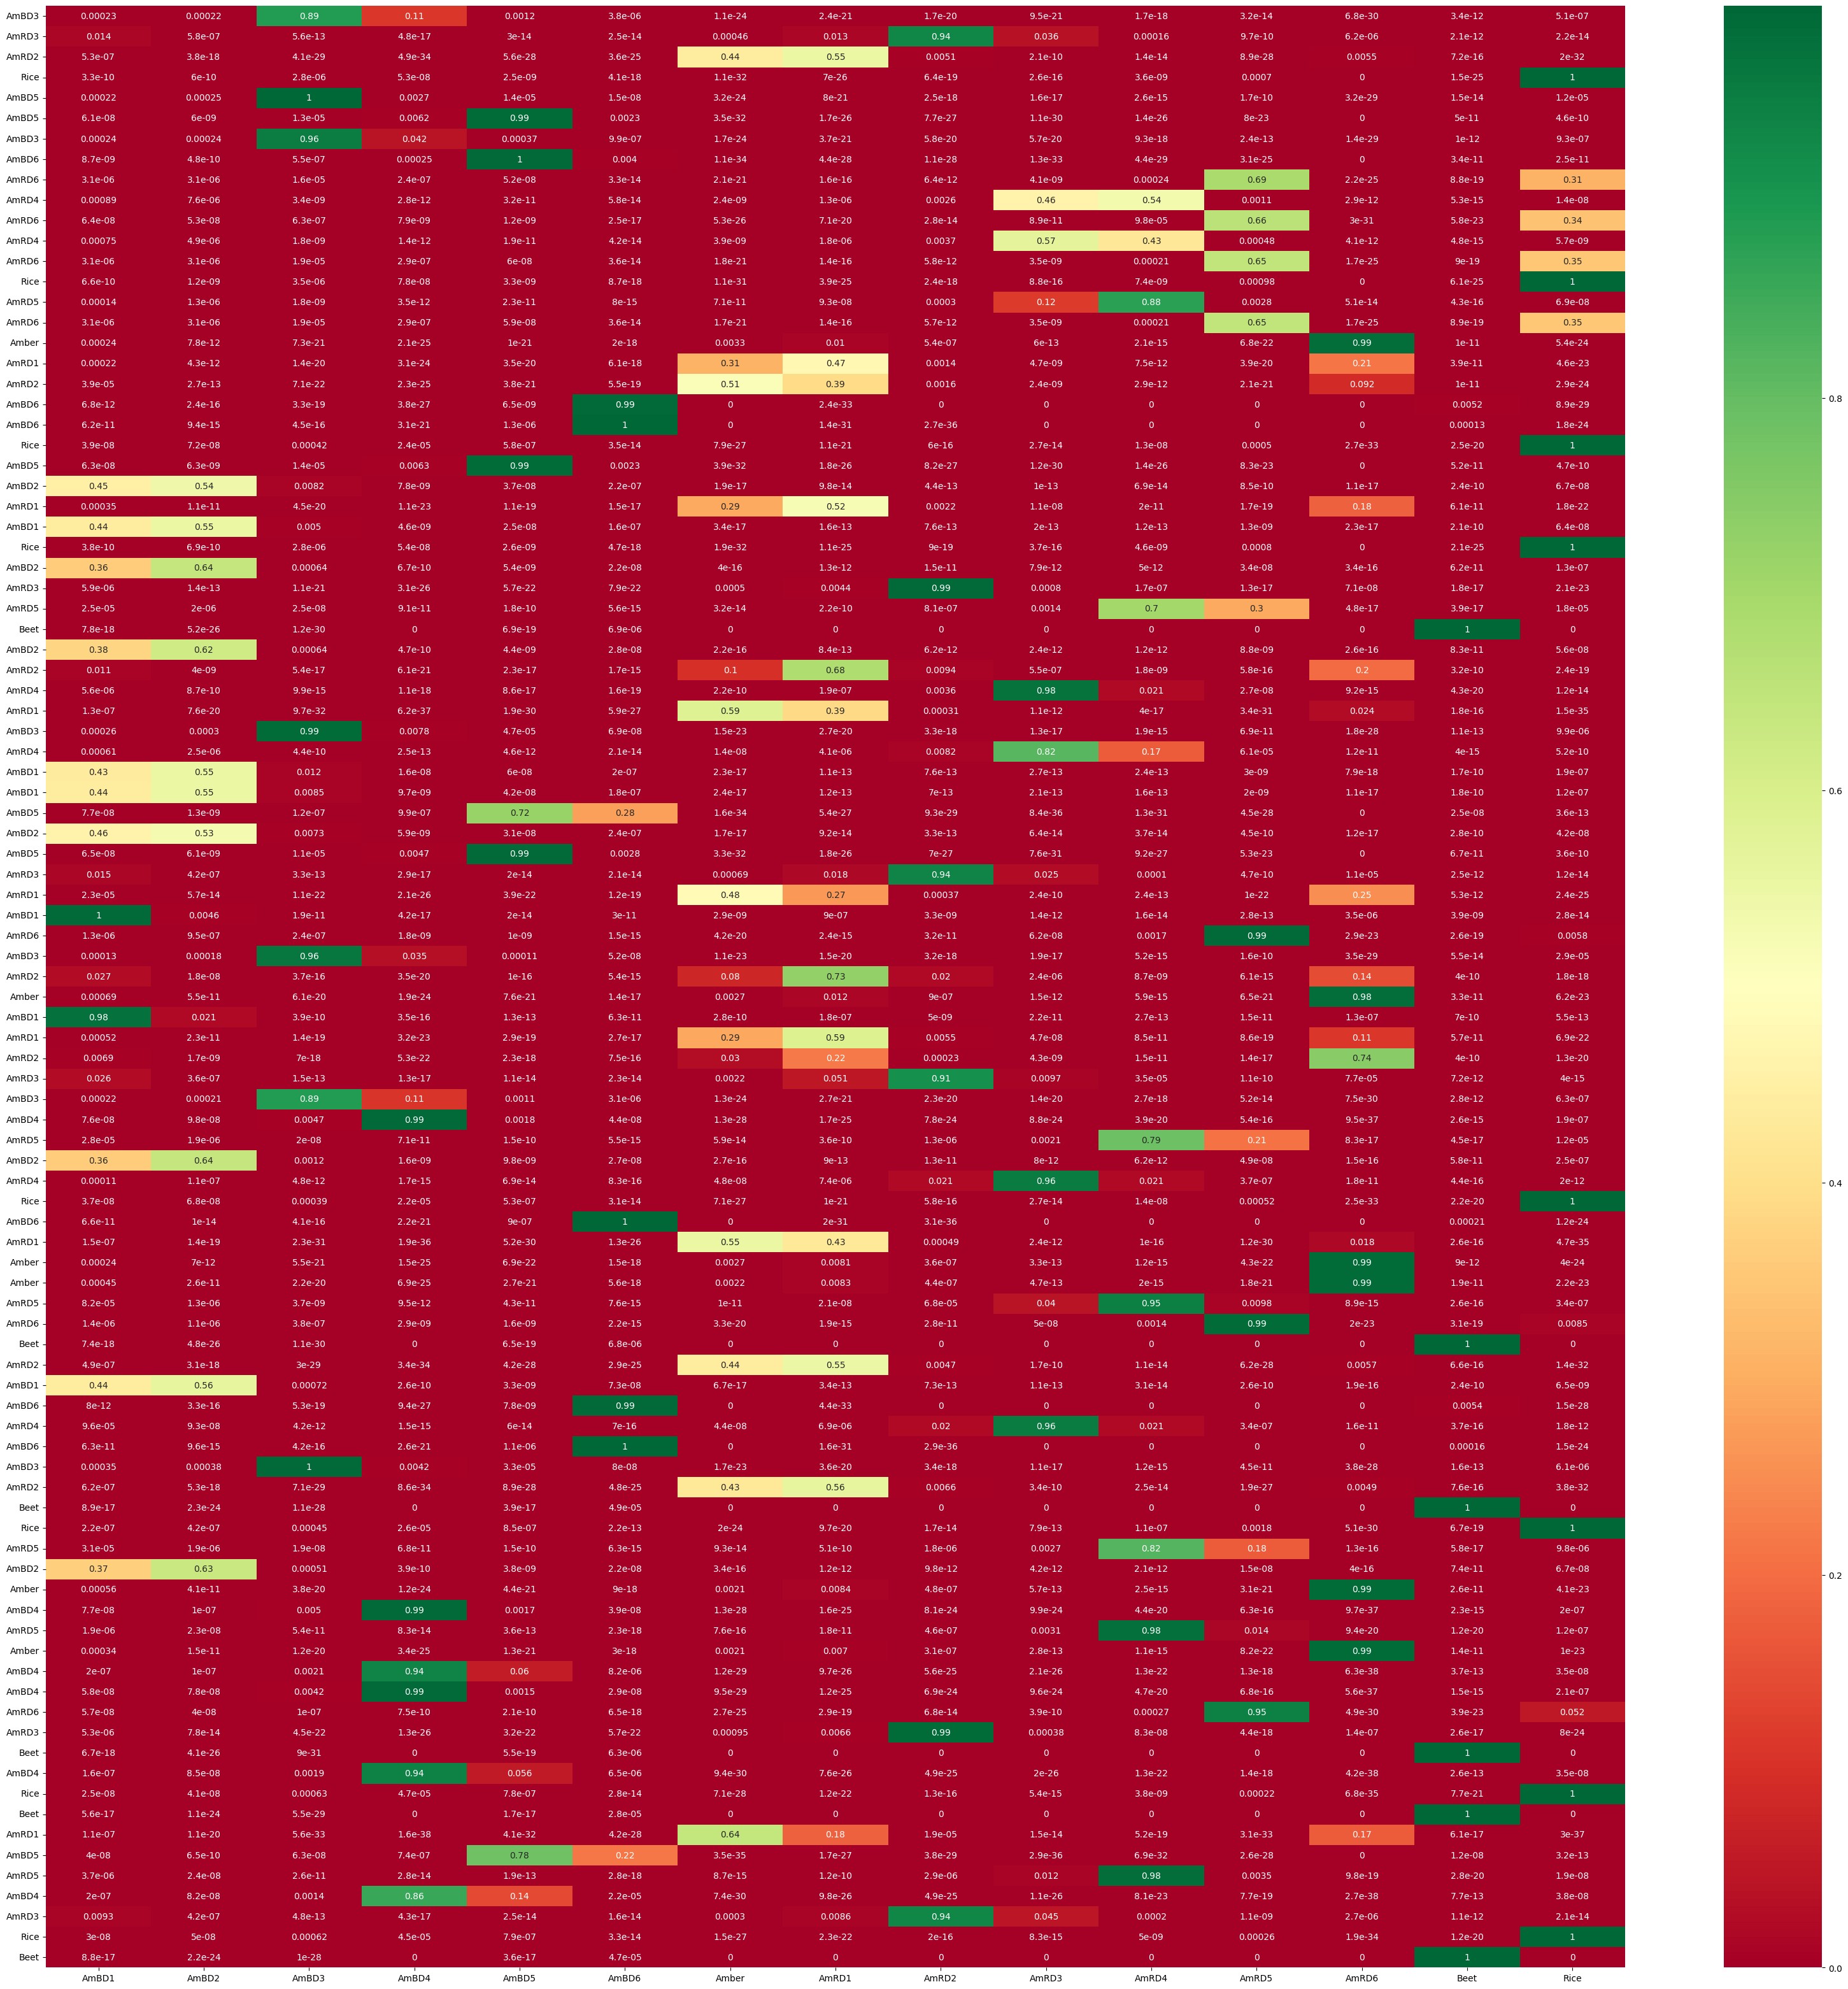

In [15]:
#plot predicted against real values
pred=ann.predict(X_test)
pred=np.asarray(pred)

#Make heatmap of classifcation predictions 
import seaborn as sns
#create list of labels: ie turn the 1d nparray into a list
y_labels=y_test_realnames.tolist()
X_labels=classlist
pyplot.figure(figsize=(40,40))
#plot heat map
m=sns.heatmap(pred, annot=True, cmap="RdYlGn", xticklabels=X_labels, yticklabels=y_labels)
pyplot.show(m)


We can also display the results as a confusion matrix which is easier on the eyes. 

3/3 [==============================] - 0s 1ms/step


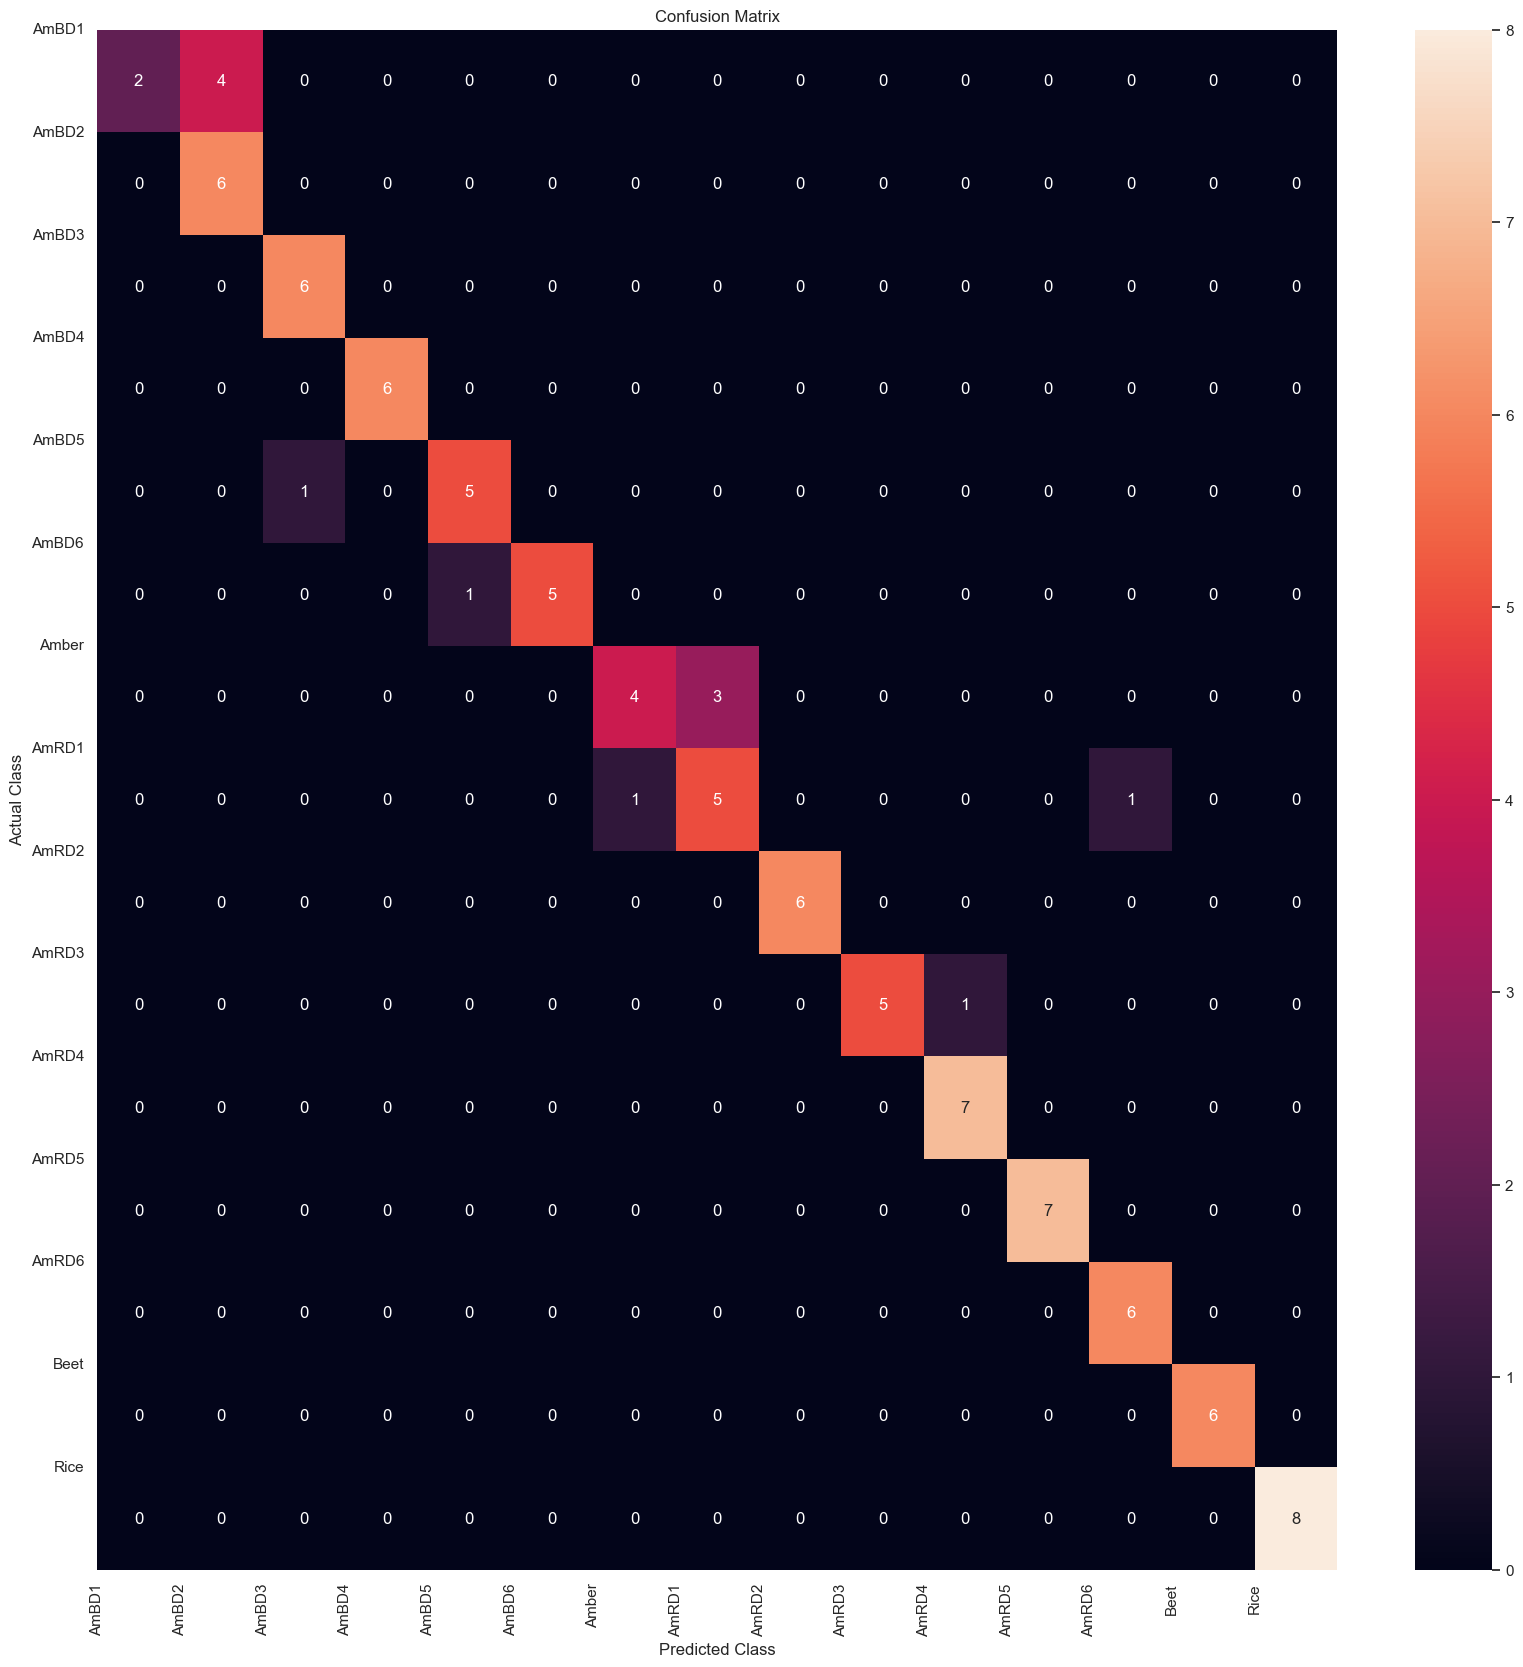

In [17]:
#plot predicted against real values
pred=ann.predict(X_test)
pred=np.asarray(pred)
predictions=np.argmax(pred,axis=1)
#create list of labels: ie turnthe 1d nparray into a list
y_rounded_labels=np.argmax(y_test, axis=1)
X_labels=classlist
num_ticks=list(range(len(X_labels)))
y_labels=y_test_realnames.tolist()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_rounded_labels, predictions)
sns.set(font_scale=1) # Adjust to fit
fig, ax = plt.subplots(figsize=(20,20))  
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_xticks(num_ticks)
ax.set_yticks(num_ticks)
ax.xaxis.set_ticklabels(X_labels);
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=360)
ax.yaxis.set_ticklabels(X_labels);

Saving the model.

In [ ]:
from keras.models import load_model
ann.save('Amber Maple Model 09-28-22')  # creates a HDF5 file
del ann  # deletes the existing model